In [1]:
import time
import colorsys
import json
from sys import path
import pandas as pd
from pandas.core.common import flatten
import numpy as np
import matplotlib.pyplot as plt

path.append('../')
from users import users

In [ ]:
# формат докстрингов

'''
Функция ...

Параметры
---------

Возвращаемое значение
---------------------

Автор
-----

'''

# Какие должны быть графики  

## Реализовано
1. Онлайн для отдельного человека в течение дня
1. Количество человек в онлайне по минутам
    * Преобразовывать сырые данные в выборки по пять минут для уплавнения графика и увеличения одновременного числа людей
    * График за один день
    * Возможность наложения двух графиков для сравнения
    * Чекбокс линии тренда на графики
1. Сумма времени, проведенного в вк по часам
    * Сколько времени за день в онлайне был отдельный человек (с погрешностью на основании количества промежутков записи - *провел в сети 1:01 или 1:05*)
    * Сколько времени за несколько дней в онлайне был отдельный человек *(box plot со средним и отклонениями)*
    * Суммарное время в сети (это модно, типа считать сколько миллиордов часов посмотрели пользователи ютуба)
1. Медианная и средняя сессия в течение дня *(просто число)*
1. Средняя и медианная длительность сессии по часам *(столбчатая диаграмма для среднего и линия для медианы)*  

## Не реализовано

### Просто
1. Самая часто используемая платформа
1. Сравнение среднего времени (одной сессии, в день) по платформам
1. Гистограмма длительности сессий 

### Сложно
1. Время отхода ко сну
1. Время подъема
1. Средняя продолжительность сна
1. Корреляция времени отхода ко сну с рейтингом студента
1. Время отхода ко сну в зависимости от пола студента

# Обработка времени

In [2]:
# https://i-leon.ru/tools/time
def to_timestamp(day=1, month=1, year=2022, hour=0, minute=0, second=0, epoch=0):
    '''
    Функция преобразовывает набор аргументов (день, месяц, год, час, минута, секунда)
    или число формата Unix timestamp в тип pandas.Timestamp

    Параметры
    ---------
    day : int
    month : int
    year : int
    hour : int
    minute : int
    second : int
    epoch : int

    Возвращаемое значение
    ---------------------
    t : pandas.Timestamp

    Автор
    -----
    Иван Чеканов
    '''
    if epoch:
        t = pd.to_datetime(epoch, unit="s")
    else:
        s = f"{hour}:{minute}:{second}, {day}.{month}.{year}"
        t = time.strptime(s, "%H:%M:%S, %d.%m.%Y")
        t = time.mktime(t)
        t = pd.to_datetime(t, unit="s")
    t = t.tz_localize("UTC").tz_convert("Europe/Moscow")
    return t


In [3]:
def to_unix(timestamp):
    '''
    Функция преобразовывает pandas.Timestamp в число формата Unix timestamp

    Параметры
    ---------
    timestamp : pandas.Timestamp
        timestamp в формате pandas 

    Возвращаемое значение
    ---------------------
    t : int
        число формата Unix timestamp

    Автор
    -----
    Иван Чеканов
    '''
    base = pd.Timestamp("1970-01-01")
    base = base.tz_localize("UTC").tz_convert("Europe/Moscow")
    t = (timestamp - base) // pd.Timedelta('1s')
    return t


Проверка

In [28]:
print(to_timestamp(epoch=1640457061))
print(to_unix(to_timestamp(epoch=1640457061)))


2021-12-25 21:31:01+03:00
1640457061


# Чтение файлов

In [4]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

def read_json(path, start, end):
    '''
    Функция получает на вход два timestamp -- начало и конец интересующего периода.
    Затем автоматически выбирает нужные файлы в указанной папке и возвращает данные по всем пользователям за интересующий период.

    Параметры
    ---------
    path : str
        путь к папке с файлами (json) информации о сессиях
    start : pandas.Timestamp
        начало временного промежутка
    end : pandas.Timestamp
        конец временного промежутка

    Возвращаемое значение
    ---------------------
    data : dict
        словарь с информацией о сессиях пользователей за выбранный период 

    Автор
    -----
    Иван Чеканов
    '''
    data = {user: [] for user in users}
    start_unix = to_unix(start)
    end_unix = to_unix(end)
    rng = pd.date_range(start, end, freq="1D")
    for tm_stmp in rng:
        name = f'{str(tm_stmp.day).zfill(2)}-{str(tm_stmp.month).zfill(2)}-{tm_stmp.year}.json'
        with open(path + name, 'r', encoding='utf-8') as file:
            raw = json.load(file)
        for user in users:
            data[user] += [i for i in raw[user] if
                           i['end'] > start_unix and i['begin'] < end_unix]
    return data


Проверка

In [5]:
read_json('../clear_data/', to_timestamp(17, 3), to_timestamp(18, 3, hour=12))


{'Liza Butenko': [{'platform': 2, 'begin': 1647464670, 'end': 1647465470},
  {'platform': 2, 'begin': 1647465960, 'end': 1647466261},
  {'platform': 7, 'begin': 1647466266, 'end': 1647466605},
  {'platform': 2, 'begin': 1647466610, 'end': 1647466775},
  {'platform': 2, 'begin': 1647467000, 'end': 1647467295},
  {'platform': 2, 'begin': 1647468270, 'end': 1647468590},
  {'platform': 2, 'begin': 1647469345, 'end': 1647469705},
  {'platform': 2, 'begin': 1647476060, 'end': 1647476500},
  {'platform': 2, 'begin': 1647507451, 'end': 1647508325},
  {'platform': 2, 'begin': 1647509066, 'end': 1647509480},
  {'platform': 2, 'begin': 1647510401, 'end': 1647511201},
  {'platform': 2, 'begin': 1647511350, 'end': 1647515701},
  {'platform': 7, 'begin': 1647515706, 'end': 1647516045},
  {'platform': 2, 'begin': 1647516050, 'end': 1647519821},
  {'platform': 2, 'begin': 1647519876, 'end': 1647520510},
  {'platform': 2, 'begin': 1647524010, 'end': 1647524370},
  {'platform': 2, 'begin': 1647524576, '

# Онлайн-активность человека

In [108]:
# https://question-it.com/questions/1862232/kak-raskrasit-tochki-dannyh-na-osnove-nekotoryh-pravil-v-matplotlib
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

def graph_daily_activity(user, start, end):
    '''
    Функция генерирует график активности пользователя с цветовой маркировкой длительности непрерывной сессии за указанный период.

    Параметры
    ---------
    user : str
        имя пользователя, о котором требуется получить информацию
    start : pandas.Timestamp
        начало временного промежутка
    end : pandas.Timestamp
        конец временного промежутка

    Возвращаемое значение
    ---------------------
    fig : matplotlib.pyplot.figure
        объект figure с одним графиком и необходимыми подписями к нему

    Автор
    -----
    Иван Чеканов
    '''
    data = read_json('../clear_data/', start, end)
    try:
        data = data[user]
    except:
        print("User does not exist.")
        return None
    # список списков, состоящих из timestamp с шагом 5 секунд и соответствющих периодам активности пользователя
    period = [pd.date_range(to_timestamp(epoch=session['begin']), to_timestamp(
        epoch=session['end']), freq='5S') for session in data]  
    # вспомогательный список, в котором хранятся цвета для заливки точек
    color = []
    # коэффициент скорости смены зеленого на красный
    KR = 0.12
    for slot in period:
        h = 120/360
        l = 1
        for _ in range(len(slot)):
            if h-0.015*KR > 0:
                h -= 0.01*KR
                l -= 0.002*KR
            elif l-0.01*KR > 0.5:
                l -= 0.01*KR
            color += [colorsys.hsv_to_rgb(h, 1, l)]
    # преобразовываем двумерный массив в одномерный
    period = list(flatten(period))
    # список точек, которые будут окрашены в цвета
    activity = [1]*len(period)
    # временная шкала, вспомогательный список
    time_tick = pd.date_range(start, end, freq="1H")
    # фактически отображаемые на графике подписи оси Х
    time_tick_labels = [i.strftime("%H:%M") for i in time_tick]
    fig, plt1 = plt.subplots()
    fig.set_dpi(100)
    fig.set_facecolor('w')
    fig.set_size_inches((17, 1.35))
    plt1.set_title(
        f'Активность пользователя {user} в период {start.strftime("%d.%m.%Y %H:%M")} — {end.strftime("%d.%m.%Y %H:%M")}')
    plt1.scatter(period, activity, marker='o', c=color)
    plt1.set_xlim((start, end))
    plt1.set_xticks(time_tick)
    plt1.set_xticklabels(time_tick_labels)
    plt1.set_yticks([])
    plt1.set_ylim((0.75, 1.25))
    plt1.set_xlabel("Время")
    fig.tight_layout()
    return fig


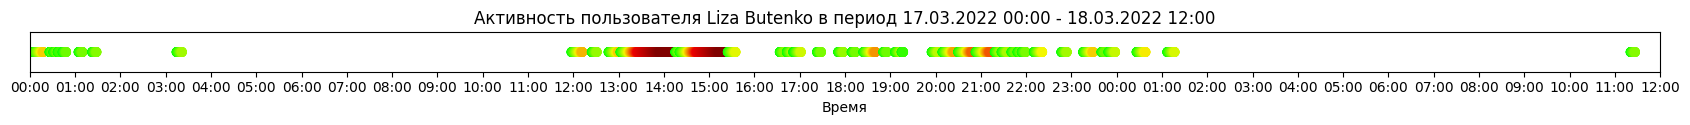

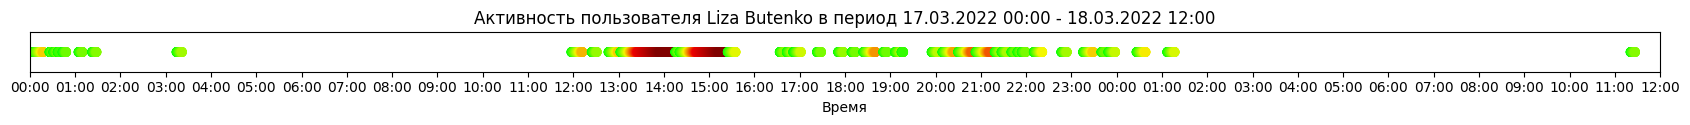

In [109]:
daily_activity_graph(list(users.keys())[0], to_timestamp(17, 3), to_timestamp(18, 3, hour=12))


# Количество человек в онлайне

In [30]:
def graph_online_counter(start, end):
    data = read_json('../clear_data/', start, end)
    time_tick = pd.date_range(start, end, freq='5S')
    counter = {t: 0 for t in time_tick}
    for user in data.keys():
        for slot in data[user]:
            tstamps = pd.date_range(max(to_timestamp(epoch=slot['begin']), start), min(
                to_timestamp(epoch=slot['end']), end), freq='5S')
            for i in tstamps:
                counter[i] += 1
    counter = list(counter.values())
    fig, plt1 = plt.subplots()
    fig.set_dpi(100)
    fig.set_facecolor('w')
    fig.set_size_inches((17, 7))
    plt1.set_title(
        f'Активность пользователей в период {start.strftime("%d.%m.%Y %H:%M")} — {end.strftime("%d.%m.%Y %H:%M")}')
    plt1.plot(time_tick, counter)
    plt1.set_xlim((start, end))
    time_tick = pd.date_range(start, end, freq='1H')
    time_tick_labels = [i.strftime('%H:%M') for i in time_tick]
    plt1.set_xticks(time_tick)
    plt1.set_xticklabels(time_tick_labels)
    plt1.set_xlabel('Время')
    plt1.set_ylabel('Количество пользователей в сети')
    fig.tight_layout()
    return fig
    

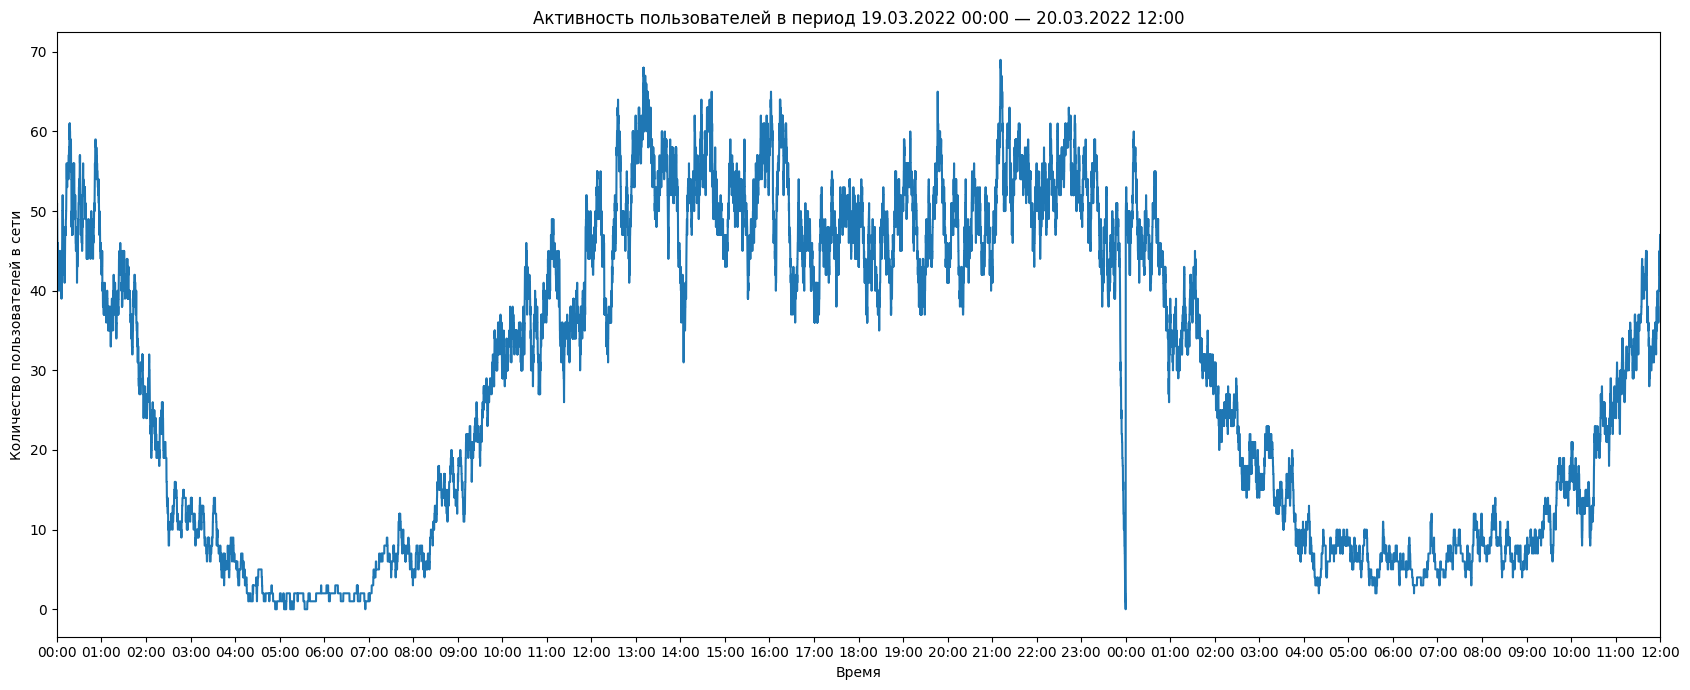

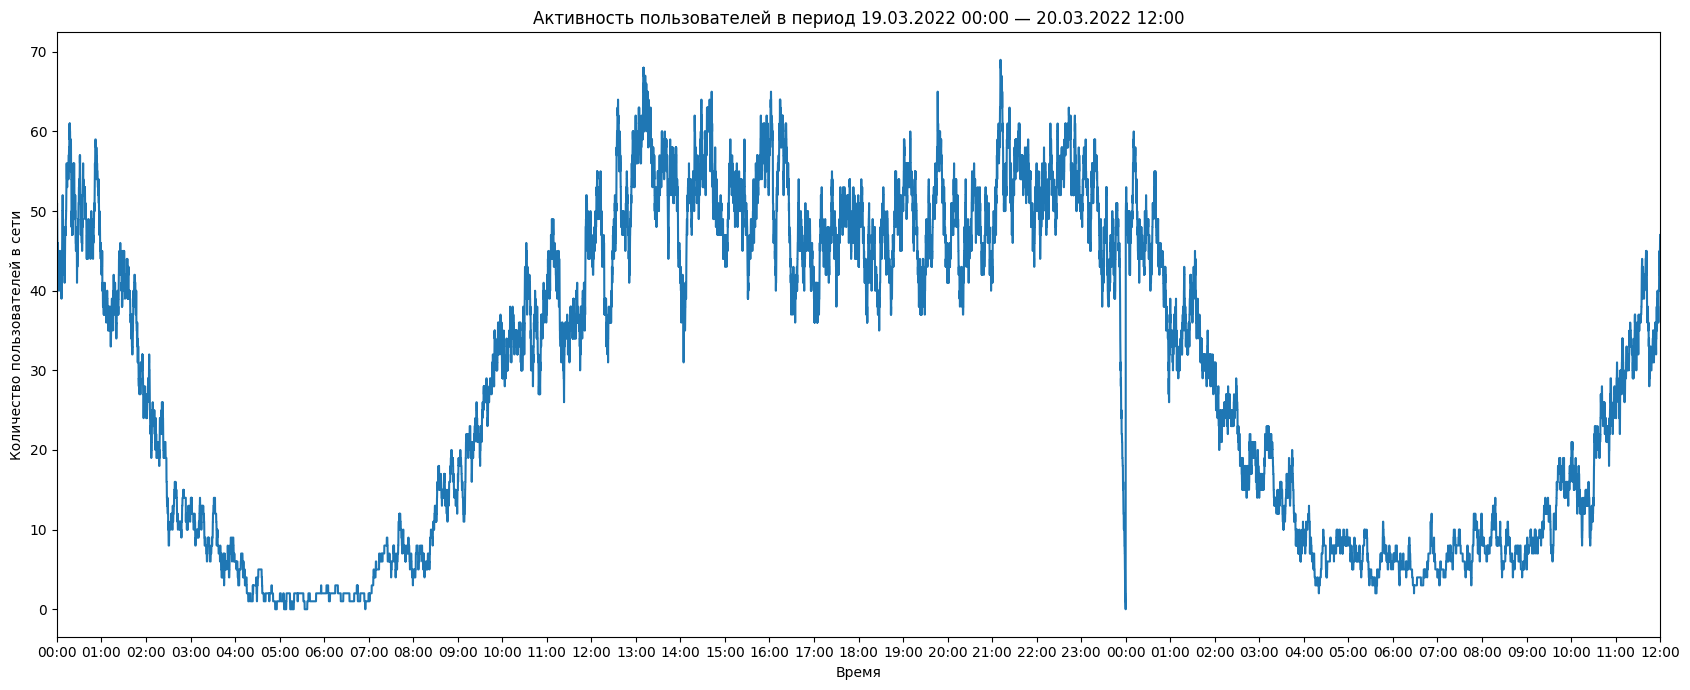

In [35]:
graph_online_counter(to_timestamp(19, 3), to_timestamp(20, 3, hour=12))


-------------

#### График с наложением

In [ ]:
fig, plt1 = plt.subplots()
fig.set_dpi(100)
fig.set_size_inches((17, 7))

for day in range(0, DAY_END-DAY_START+1):
    raw_tmp = pd.read_csv(f"../data_course/data-{str(day+DAY_START).zfill(2)}-{MONTH_STR}.csv",
                          delimiter=", ", engine="python")
    datas = pd.Series(to_timestamp(epoch=a-60*60*24*day)
                      for a in raw_tmp["Дата"])
    online_ctr = pd.Series(
        sum(raw_tmp.iloc[i:i+1, 1:].values.tolist()[0]) for i in range(len(raw_tmp)))
    online_ctr_smooth = pd.Series(online_ctr.values).rolling(30).mean()
    plt1.plot(datas, online_ctr_smooth, label=f"{day+DAY_START}.{MONTH}")
plt1.legend()
plt1.set_xlim((to_timestamp(DAY_START, MONTH, YEAR, 6, 45),
              to_timestamp(DAY_START+1, MONTH, YEAR, 7, 15)))
plt1.set_xticks(act_time_tick)
plt1.set_xticklabels(act_time_tick_labels)
plt1.set_xlabel("Время")
plt1.set_ylabel("Количество человек")
plt1.set_title(
    f"Количество человек в онлайне в период {DAY_START_STR}.{MONTH_STR} -- {DAY_END_STR}.{MONTH_STR}")
fig.set_facecolor("w")
fig.tight_layout()


# Время в сети
**ДО 28.12.2021:** При сборе данных применялось округление в большую сторону к 30-секундному промежутку. То есть, если ты зашел в ВК на 2 секунды, то это будет отображено так же, как и если бы в сети находился 29 секунд. То же самое с 31 и 59 секундами -- это одна минута.  
Чтобы немного нивелировать эту погрешность, применяется коэффициент 0.75 (просто из головы).  
**ПОСЛЕ 28.12.2021:** После чтения файла выполняется чистка от т.н. "дребезга", поэтому если в течение `RATE*delta` секунд (при `RATE==delta==5` получим 25-секундные интервалы) человек несколько раз находился в сети, то промежуток между входами тоже считается онлайном.
### Сколько провел в сети отдельный человек
#### За день

In [ ]:
wasted_time = (sum(raw.iloc[:, 1:].values)*RATE)/60
err = [0]*len(names)
t = [0]*len(names)
for data in raw.iloc[:, 1:].values:
    for j in range(len(data)):
        if data[j] == 0 and t[j] == 1:
            err[j] += RATE/60
            t[j] = 0
        if data[j] == 1:
            t[j] = 1
wasted_time = [i-j/2 for i, j in zip(wasted_time, err)]
guys = list(raw.axes[1][1:])
fig, ax = plt.subplots(dpi=100, figsize=(12, 7))
ax.bar(guys, wasted_time, yerr=err)
ax.set_title(
    f"Время в ВК за сутки {DAY_START_STR}.{MONTH_STR} 7:00 -- {str(DAY_START+1).zfill(2)}.{MONTH_STR} 7:00 для отдельных участников")
ax.set_ylabel(f"Время, мин")
# plt.text(18.3,165,"Чёрным цветом обозначена погрешность")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
fig.set_facecolor("w")
fig.tight_layout()


#### За несколько дней

In [ ]:
t = np.array([np.nan]*len(names))
for i in range(DAY_START, DAY_END+1):
    raw_tmp = pd.read_csv(f"../data_course/data-{str(i).zfill(2)}-{MONTH_STR}.csv",
                          delimiter=", ", engine="python")
    if to_timestamp(epoch=raw_tmp["Дата"][0]) >= to_timestamp(29, 12, 2021):
        for i in range(1, len(names)+1):
            arr = raw_tmp.iloc[:, i:i+1].values
            for j in range(len(arr)-DELTA):
                if arr[j] != 0 and any(arr[j+a] != 0 for a in range(1, DELTA+1)):
                    a = j+1
                    while arr[a] != 1 and a < len(arr)-1:
                        arr[a] = 1
                        a += 1
            raw_tmp[names[i-1]] = arr
    wasted_time = (sum(raw_tmp.iloc[:, 1:].values)*RATE)/60
    t = np.vstack((t, wasted_time))
t = pd.DataFrame(t, columns=names)
ax = t.boxplot(grid=True, figsize=(12, 7))
ax.set_ylabel("Время, мин")
if (DAY_END-DAY_START+1) in (2, 3, 4, 22, 23, 24, 32, 33, 34):
    word = "дня"
elif (DAY_END-DAY_START+1) in (1, 21, 31):
    word = "день"
else:
    word = "дней"
ax.set_title(
    f"Время во ВКонтакте за {DAY_END-DAY_START+1} {word} ({DAY_START_STR}.{MONTH_STR} -- {DAY_END_STR}.{MONTH_STR}) посуточно")
fig = ax.get_figure()
fig.set_dpi(100)
plt.xticks(rotation=45, ha="right")
fig.set_facecolor("w")
fig.tight_layout()


### Столбцы по часам

In [ ]:
wasted_time = [0]*len(act_time_tick[1:])
# next_steps[0] == raw.iloc[0:1, 0]
i = 0
for j, date in enumerate(raw["Дата"]):
    if act_time_tick[i+1] <= date:
        i += 1
    wasted_time[i] += sum(raw.iloc[j:j+1, 1:].values.tolist()[0])*RATE/60
fig, ax = plt.subplots(dpi=100, figsize=(14, 7))
ax.bar(act_time_tick_labels[1:], wasted_time)
ax.set_title(
    f"Суммарное время онлайна за каждый час в период {DAY_START_STR}.{MONTH_STR} 7:00 -- {str(DAY_START+1).zfill(2)}.{MONTH_STR} 7:00 для всех участников")
ax.set_ylabel(f"Время, мин")
fig.set_facecolor("w")
fig.tight_layout()


# Средняя и медианная длительность сессии за день
### Просто числа

In [ ]:
wasted_time = []
t = 0
for i in range(1, len(names)+1):
    for j in raw.iloc[:, i:i+1].values:
        if j == 0:
            if t != 0:
                wasted_time.append(t)
            t = 0
        else:
            t += RATE
print("Среднее, сек:", sum(wasted_time)/len(wasted_time))
print("Медиана, сек:", sorted(wasted_time)[len(wasted_time)//2])


### Длительность сессии по часам

In [ ]:
wasted_time = [[] for _ in range(len(act_time_tick)-1)]
t = [0]*(len(act_time_tick)+1)
i = 0
for data in raw.values:
    if act_time_tick[i+1] <= data[0]:
        i += 1
    for n, j in enumerate(data[1:]):
        if j == 0:
            if t[n] != 0:
                wasted_time[i].append(t[n])
            t[n] = 0
        else:
            t[n] += RATE
t_sr = []
for a in wasted_time:
    if a:
        t_sr.append((sum(a)/len(a)))
    else:
        t_sr.append(0)
t_med = []
for a in range(len(wasted_time)):
    if wasted_time[a]:
        t_med.append(sorted(wasted_time[a])[len(wasted_time[a])//2])
    else:
        t_med.append(0)
fig, ax = plt.subplots(dpi=100, figsize=(14, 7))
ax.bar(act_time_tick_labels[1:], t_sr, label="Среднее")
ax.plot(act_time_tick_labels[1:], t_med, color="r", label="Медианное")
ax.legend()
ax.set_title(
    f"Среднее время в сети всех участников группы по часам за период {DAY_START_STR}.{MONTH_STR} 7:00 -- {str(DAY_START+1).zfill(2)}.{MONTH_STR} 7:00")
ax.set_ylabel(f"Время, сек")
fig.set_facecolor("w")
fig.tight_layout()


## Значение медианы по дням за период

In [ ]:
fig, ax = plt.subplots(dpi=100, figsize=(14, 2.5))
prev = 0
for m in range(DAY_START, DAY_END+1):
    # for m in range(DAY_START, DAY_START+3):
    raw_tmp = pd.read_csv(f"../data_course/data-{str(m).zfill(2)}-{MONTH_STR}.csv",
                          delimiter=", ", engine="python")
    if to_timestamp(epoch=raw_tmp["Дата"][0]) >= to_timestamp(29, 12, 2021):
        for i in range(1, len(names)+1):
            arr = raw_tmp.iloc[:, i:i+1].values
            for j in range(len(arr)-DELTA):
                if arr[j] != 0 and any(arr[j+a] != 0 for a in range(1, DELTA+1)):
                    a = j+1
                    while arr[a] != 1 and a < len(arr)-1:
                        arr[a] = 1
                        a += 1
            raw_tmp[names[i-1]] = arr
    raw_tmp["Дата"] = [to_timestamp(epoch=a) for a in raw_tmp["Дата"]]
    act_time_tick = [to_timestamp(m, MONTH, YEAR, j) for j in hrs1]
    act_time_tick += [to_timestamp(m+1, MONTH, YEAR, j) for j in hrs2]
    wasted_time = [[] for _ in range(len(act_time_tick)-1)]
    t = [0]*(len(act_time_tick)+1)
    i = 0
    for data in raw_tmp.values:
        if act_time_tick[i+1] <= data[0]:
            i += 1
        for n, j in enumerate(data[1:]):
            if j == 0:
                if t[n] != 0:
                    wasted_time[i].append(t[n])
                t[n] = 0
            else:
                t[n] += RATE
    t_med = [prev]
    # t_med = []
    for a in range(len(wasted_time)):
        if wasted_time[a]:
            t_med.append(sorted(wasted_time[a])[len(wasted_time[a])//2])
        else:
            t_med.append(0)
    ax.plot(act_time_tick, t_med)
    prev = t_med[-1]

ax.set_title(
    f"Медианная длительность сессии участников группы по часам за период {DAY_START_STR}.{MONTH_STR} 7:00 -- {str(DAY_END+1).zfill(2)}.{MONTH_STR} 7:00")
ax.set_ylabel(f"Время, сек")
# ax.set_ylim([-5, 65])
fig.set_facecolor("w")
fig.tight_layout()
